# Case Study: Sliding-window glass event detection
构造长音频（背景床 + glass 混入），滑窗推理并做事件级评估。


## 导入与配置
设置路径、模型、混音与评估参数（集中于 config）。


In [1]:
import json
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import soundfile as sf
import torch

sys.path.append("src")

from src.config import (
    AUDIO_DIR,
    META_FILE,
    SR,
    WINDOW_HOP,
    WINDOW_SECONDS,
    POSITIVE_LABELS,
    CASE_STUDY_DEFAULTS,
    CASE_STUDY_DIR,
    CASE_STUDY_SCHEMA_VERSION,
    SEED,
)
from src.event_detection import (
    ClipSpec,
    GLASS_LABEL,
    build_background_bed,
    mix_glass_on_bed,
    sliding_log_mel_windows,
    merge_events,
    match_events,
    match_events_with_pairs,
    bucket_recall_by_snr,
    bucket_delay,
    predict_glass_probs,
    smooth_probabilities,
)
from src.inference import create_onnx_session, load_torch_checkpoint

params = {**CASE_STUDY_DEFAULTS}
RNG_SEED = SEED

TARGET_BED_DURATION = params["target_bed_duration"]
BACKGROUND_GAIN_DB = params["background_gain_db"]
GLASS_GAIN_DB = params["glass_gain_db"]
START_OFFSET_RANGE = params["start_offset_range"]
GAP_RANGE = params["gap_range"]
SNR_RANGE_DB = params["snr_range_db"]
CROSSFADE_MS = params["crossfade_ms"]
SPLIT_TOP_DB = params["split_top_db"]
MIN_EVENT_DUR = params["min_event_dur"]
THRESHOLD = params["threshold"]
MERGE_GAP = params["merge_gap"]
TOLERANCE = params["tolerance"]
SMOOTH_K = int(params.get("smooth_k", 1) or 1)

CASE_STUDY_DIR.mkdir(parents=True, exist_ok=True)
RUN_CONFIG_PATH = CASE_STUDY_DIR / "run_config.json"
MIX_PATH = CASE_STUDY_DIR / "mix.wav"


## 保存本次运行配置
记录混音/评估参数，便于复现与比较。


In [2]:
run_config = {
    "schema": CASE_STUDY_SCHEMA_VERSION,
    "params": params,
    "rng_seed": RNG_SEED,
    "mix_path": str(MIX_PATH),
    "meta_file": str(META_FILE),
}
RUN_CONFIG_PATH.write_text(json.dumps(run_config, indent=2))
print(f"Saved config to {RUN_CONFIG_PATH}")


Saved config to /workspace/cache/mel64/case_study/run_config.json


## 收集片段并准备背景床
加载外部 glass 片段，采样多段背景，拼接 ~60s 背景床。


In [3]:
EXTERNAL_DIR = Path("data/external")
external_glass_paths = sorted(EXTERNAL_DIR.glob("glass_ext_*"))
if not external_glass_paths:
    raise FileNotFoundError("No external glass clips found under data/external")

glass_specs = [ClipSpec(path=p, label=GLASS_LABEL, gain_db=GLASS_GAIN_DB) for p in external_glass_paths]

meta_df = pd.read_csv(META_FILE)
non_glass_df = meta_df[~meta_df["category"].isin(POSITIVE_LABELS.keys())]
# 多取背景，循环到目标时长
bg_sample_n = max(18, len(glass_specs) * 4)
bg_samples = non_glass_df.sample(n=bg_sample_n, random_state=RNG_SEED, replace=len(non_glass_df) < bg_sample_n)
background_specs = [
    ClipSpec(path=AUDIO_DIR / row["filename"], label="background", gain_db=BACKGROUND_GAIN_DB)
    for _, row in bg_samples.iterrows()
]

for clip in glass_specs:
    print(f"glass  | {clip.path.name}")
print(f"background clips: {len(background_specs)} (sampled)")


glass  | glass_ext_01.wav
glass  | glass_ext_02.flac
glass  | glass_ext_03.wav
glass  | glass_ext_04.wav
glass  | glass_ext_05.wav
background clips: 20 (sampled)


## 构造背景床 (约 60s)
将背景片段交叉淡入淡出拼接成底床。


In [4]:
background_bed = build_background_bed(
    background_specs,
    sr=SR,
    target_duration=TARGET_BED_DURATION,
    crossfade_ms=CROSSFADE_MS,
    normalize=True,
)
print(f"Background bed duration: {len(background_bed)/SR:.2f}s")


Background bed duration: 60.00s


## 叠加 glass 事件并切分真值
随机顺序与间隔叠加 glass，自动检测片段内的有效击碎段作为真值。


In [5]:
rng = np.random.default_rng(RNG_SEED)
audio, gt_events = mix_glass_on_bed(
    background_bed,
    glass_specs,
    sr=SR,
    start_offset_range=START_OFFSET_RANGE,
    gap_range=GAP_RANGE,
    crossfade_ms=CROSSFADE_MS,
    snr_range_db=SNR_RANGE_DB,
    split_top_db=SPLIT_TOP_DB,
    min_event_dur=MIN_EVENT_DUR,
    seed=None,
    rng=rng,
)
sf.write(MIX_PATH, audio, SR)

print(f"Mix duration: {len(audio)/SR:.2f}s, saved to {MIX_PATH}")
for ev in gt_events:
    snr_txt = f", SNR={ev.snr_db:.1f}dB" if ev.snr_db is not None else ""
    print(f"GT | {ev.source} | {ev.start:.2f}-{ev.end:.2f}s{snr_txt}")


Mix duration: 60.00s, saved to /workspace/cache/mel64/case_study/mix.wav
GT | glass_ext_05 | 5.22-5.62s, SNR=7.5dB
GT | glass_ext_05 | 5.64-6.01s, SNR=7.5dB
GT | glass_ext_03 | 9.98-10.86s, SNR=8.9dB
GT | glass_ext_04 | 19.32-19.99s, SNR=7.9dB
GT | glass_ext_02 | 21.85-22.32s, SNR=6.3dB
GT | glass_ext_01 | 26.55-27.01s, SNR=8.6dB
GT | glass_ext_01 | 27.34-27.43s, SNR=8.6dB
GT | glass_ext_01 | 29.01-29.57s, SNR=8.6dB
GT | glass_ext_01 | 29.71-29.80s, SNR=8.6dB
GT | glass_ext_01 | 29.82-29.94s, SNR=8.6dB
GT | glass_ext_01 | 31.52-32.03s, SNR=8.6dB
GT | glass_ext_01 | 32.33-32.42s, SNR=8.6dB


## 生成滑窗 mel 批次
使用训练同参 (1s/0.5s) 转换为 log-mel。


In [6]:
batch, spans = sliding_log_mel_windows(
    audio,
    sr=SR,
    window_seconds=WINDOW_SECONDS,
    hop_seconds=WINDOW_HOP,
    min_coverage=0.7,
)
print(f"Windows: {len(spans)}, batch shape: {tuple(batch.shape)}")


Windows: 119, batch shape: (119, 1, 64, 87)


## Torch 与 ONNX 推理
批量前向得到每窗 glass 概率，并比对 Torch/ONNX，随后可选平滑。


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt_path = Path("cache/experiments/tinyglassnet_best.pt")
onnx_path = Path("cache/experiments/tinyglassnet_best.onnx")

model, _ = load_torch_checkpoint(ckpt_path, device=device)
torch_probs, _ = predict_glass_probs(batch, spans, model=model, device=device)

torch_probs_smooth = smooth_probabilities(torch_probs, kernel_size=SMOOTH_K)

onnx_probs = None
max_delta = None
if onnx_path.exists():
    onnx_sess = create_onnx_session(onnx_path)
    onnx_probs, _ = predict_glass_probs(batch, spans, session=onnx_sess, device="cpu")
    max_delta = float(np.max(np.abs(np.array(torch_probs) - np.array(onnx_probs))))

print(f"Torch probs range: {min(torch_probs):.3f}–{max(torch_probs):.3f} (smooth k={SMOOTH_K})")
if onnx_probs is not None:
    print(f"ONNX probs range: {min(onnx_probs):.3f}–{max(onnx_probs):.3f}, max delta {max_delta:.4f}")


Torch probs range: 0.008–1.000 (smooth k=1)
ONNX probs range: 0.008–1.000, max delta 0.0000


## 合并窗口并评估事件（含分桶）
阈值合并窗口，允许 ±0.5s 偏移匹配，输出 P/R/F1，并按 SNR/延迟分桶。


In [8]:
pred_events = merge_events(spans, torch_probs_smooth, threshold=THRESHOLD, merge_gap=MERGE_GAP)
metrics = match_events(pred_events, gt_events, tolerance=TOLERANCE)
pairs, unmatched_gt, unmatched_pred = match_events_with_pairs(pred_events, gt_events, tolerance=TOLERANCE)
matched_gt_indices = sorted(set(range(len(gt_events))) - set(unmatched_gt))
snr_recalls = bucket_recall_by_snr(gt_events, matched_gt_indices)
delay_buckets = bucket_delay(pairs)

print("Predicted events:")
for ev in pred_events:
    print(f"pred | {ev['start']:.2f}-{ev['end']:.2f}s | max_prob={ev['max_prob']:.3f}")

print("Ground truth events:")
for ev in gt_events:
    snr_txt = f" (SNR={ev.snr_db:.1f}dB)" if ev.snr_db is not None else ""
    print(f"gt   | {ev.start:.2f}-{ev.end:.2f}s | {ev.source}{snr_txt}")

print(f"TP={metrics['tp']} FP={metrics['fp']} FN={metrics['fn']} "
    f"P={metrics['precision']:.3f} R={metrics['recall']:.3f} F1={metrics['f1']:.3f}"
)
print("SNR recalls:")
for k, v in snr_recalls.items():
    txt = "n/a" if v is None else f"{v:.3f}"
    print(f"  {k}: {txt}")

print("Delay buckets (center delta):")
for k, v in delay_buckets.items():
    print(f"  {k}: {v}")
print(f"Unmatched gt={len(unmatched_gt)} pred={len(unmatched_pred)}")


Predicted events:
pred | 4.50-6.00s | max_prob=0.930
pred | 9.50-11.50s | max_prob=0.994
pred | 15.00-16.00s | max_prob=0.798
pred | 16.50-17.50s | max_prob=0.881
pred | 18.50-20.50s | max_prob=0.996
pred | 21.50-23.00s | max_prob=0.862
pred | 26.00-27.50s | max_prob=1.000
pred | 28.50-30.00s | max_prob=1.000
pred | 31.50-32.50s | max_prob=0.865
pred | 49.00-50.50s | max_prob=0.926
Ground truth events:
gt   | 5.22-5.62s | glass_ext_05 (SNR=7.5dB)
gt   | 5.64-6.01s | glass_ext_05 (SNR=7.5dB)
gt   | 9.98-10.86s | glass_ext_03 (SNR=8.9dB)
gt   | 19.32-19.99s | glass_ext_04 (SNR=7.9dB)
gt   | 21.85-22.32s | glass_ext_02 (SNR=6.3dB)
gt   | 26.55-27.01s | glass_ext_01 (SNR=8.6dB)
gt   | 27.34-27.43s | glass_ext_01 (SNR=8.6dB)
gt   | 29.01-29.57s | glass_ext_01 (SNR=8.6dB)
gt   | 29.71-29.80s | glass_ext_01 (SNR=8.6dB)
gt   | 29.82-29.94s | glass_ext_01 (SNR=8.6dB)
gt   | 31.52-32.03s | glass_ext_01 (SNR=8.6dB)
gt   | 32.33-32.42s | glass_ext_01 (SNR=8.6dB)
TP=7 FP=3 FN=5 P=0.700 R=0.583 F1=0

## 概率时间轴可视化
画出平滑后的概率柱状并标记 GT 与预测事件。


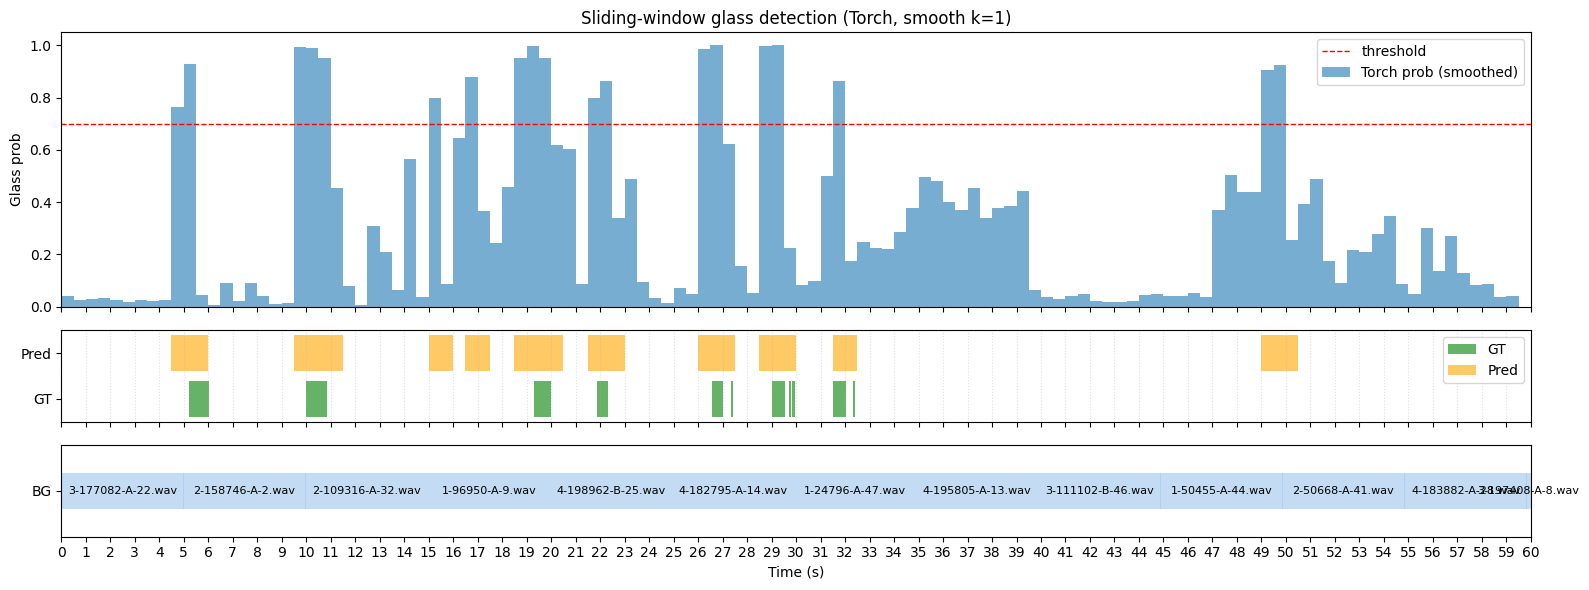

In [11]:
import matplotlib.pyplot as plt
import librosa
import numpy as np

starts = [s for s, _ in spans]
fig, axes = plt.subplots(
    3, 1, figsize=(16, 6), gridspec_kw={'height_ratios': [3, 1, 1]}, sharex=True
)
ax = axes[0]
ax.bar(starts, torch_probs_smooth, width=WINDOW_HOP, align="edge", alpha=0.6, label="Torch prob (smoothed)")
ax.axhline(THRESHOLD, color="red", linestyle="--", linewidth=1, label="threshold")
ax.set_ylabel("Glass prob")
ax.set_title(f"Sliding-window glass detection (Torch, smooth k={SMOOTH_K})")
ax.legend(loc="upper right")
ax.set_ylim(0, 1.05)

# Timeline subplot for GT/Pred
ax_t = axes[1]
pred_spans = [(ev["start"], ev["end"] - ev["start"]) for ev in pred_events]
gt_spans = [(ev.start, ev.end - ev.start) for ev in gt_events]
ax_t.broken_barh(gt_spans, (0.05, 0.4), facecolors="green", alpha=0.6, label="GT")
ax_t.broken_barh(pred_spans, (0.55, 0.4), facecolors="orange", alpha=0.6, label="Pred")
ax_t.set_ylim(0, 1)
ax_t.set_yticks([0.25, 0.75])
ax_t.set_yticklabels(["GT", "Pred"])
ax_t.grid(True, axis="x", linestyle=":", alpha=0.4)
ax_t.legend(loc="upper right")

# Background track timeline
ax_b = axes[2]
bg_spans = []
cursor = 0.0
crossfade_s = CROSSFADE_MS / 1000.0
bed_limit = len(background_bed) / SR
for spec in background_specs:
    y, _ = librosa.load(spec.path, sr=SR)
    dur = len(y) / SR
    start = cursor
    end = start + dur
    if start >= bed_limit:
        break
    bg_spans.append((start, min(dur, bed_limit - start), spec.path.name))
    cursor = end - crossfade_s

for (start, dur, name) in bg_spans:
    ax_b.broken_barh([(start, dur)], (0.3, 0.4), facecolors="#aaccee", alpha=0.7)
    ax_b.text(start + dur / 2, 0.5, name, ha='center', va='center', fontsize=8)
ax_b.set_ylim(0, 1)
ax_b.set_yticks([0.5])
ax_b.set_yticklabels(["BG"])
ax_b.set_xlabel("Time (s)")
max_time = spans[-1][1] if spans else bed_limit
xticks = np.arange(0, max(max_time, bed_limit) + 1, 1)
ax_b.set_xticks(xticks)
for axx in axes:
    axx.set_xlim(0, max(max_time, bed_limit))

plt.tight_layout()


## 试听混音并查看真值时间
播放拼接后的长音频，并列出每个 glass 片段的起止时间。


In [12]:
from IPython.display import Audio, display

print(f"Mix duration: {len(audio)/SR:.2f}s (saved at {MIX_PATH})")
print("Ground truth glass events:")
for ev in gt_events:
    snr_txt = f" (SNR={ev.snr_db:.1f}dB)" if ev.snr_db is not None else ""
    print(f"  - {ev.source}: {ev.start:.2f}-{ev.end:.2f}s{snr_txt}")

display(Audio(str(MIX_PATH), rate=SR))


Mix duration: 60.00s (saved at /workspace/cache/mel64/case_study/mix.wav)
Ground truth glass events:
  - glass_ext_05: 5.22-5.62s (SNR=7.5dB)
  - glass_ext_05: 5.64-6.01s (SNR=7.5dB)
  - glass_ext_03: 9.98-10.86s (SNR=8.9dB)
  - glass_ext_04: 19.32-19.99s (SNR=7.9dB)
  - glass_ext_02: 21.85-22.32s (SNR=6.3dB)
  - glass_ext_01: 26.55-27.01s (SNR=8.6dB)
  - glass_ext_01: 27.34-27.43s (SNR=8.6dB)
  - glass_ext_01: 29.01-29.57s (SNR=8.6dB)
  - glass_ext_01: 29.71-29.80s (SNR=8.6dB)
  - glass_ext_01: 29.82-29.94s (SNR=8.6dB)
  - glass_ext_01: 31.52-32.03s (SNR=8.6dB)
  - glass_ext_01: 32.33-32.42s (SNR=8.6dB)
